In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import randint as sp_randint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import BalancedBatchGenerator
from imblearn.keras import balanced_batch_generator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import os
from datetime import datetime
import random

In [2]:
date = '20200609'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.1.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'


class_output = 'classification_unlabelled_set_withWISE_RSCVn_periodic_20191119.csv'

#where the RF models are saved
model_first_layer = 'stat_MLP/MLP_model_hierarchical_layer_'+date
model_periodic_layer = 'stat_MLP/MLP_model_periodic_layer_'+date
model_transient_layer = 'stat_MLP/MLP_model_transient_layer_'+date
model_stochastic_layer = 'stat_MLP/MLP_model_stochastic_layer_'+date

#confusion matrixes
conf_matrix_name_first_layer = 'stat_MLP/confusion_matrix_MLP_model_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'stat_MLP/confusion_matrix_MLP_model_multiclass_'+date

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_feat_for_stats = df_feat.copy()
print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[(df_labels['source']!="ASASSN") & (df_labels['source']!="GAIADR2VS")]
#df_labels = df_labels[(df_labels['source']!="ASASSN") ]

bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)

df_labels = df_labels[(df_labels['class_source']!="ELL")]

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierarchical'] = labels['class_original']

labels.loc[ (labels['class_hierarchical'] == 'LPV') | (labels['class_hierarchical'] == 'Periodic-Other') | (labels['class_hierarchical'] == 'E')  | (labels['class_hierarchical'] == 'DSCT') | (labels['class_hierarchical'] == 'RRL') | (labels['class_hierarchical'] == 'CEP') , 'class_hierarchical'] = 'Periodic'

labels.loc[(labels['class_hierarchical'] == 'SNIa') | (labels['class_hierarchical'] == 'SNIbc') | (labels['class_hierarchical'] == 'SNII') | (labels['class_hierarchical'] == 'SLSN'), 'class_hierarchical'] = 'Transient'

labels.loc[(labels['class_hierarchical'] == 'CV/Nova')  |(labels['class_hierarchical'] == 'YSO') |     (labels['class_hierarchical'] == 'AGN') |  (labels['class_hierarchical'] == 'QSO') | (labels['class_hierarchical'] == 'Blazar')  , 'class_hierarchical'] = 'Stochastic'

cm_classes_hierarchical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierarchical'].values.shape)
labels.head()

(171284,)


,class_original,class_hierarchical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
#print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
#print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierarchical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierarchical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

#print(df['g-r_max'].values.size)
df.head()

122531


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,0.780000,0.013542,0.796,2.889,8.106832,5.217832,8.668390,5.779390,0.202128,1.155121
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.717857,0.216488,0.807,2.964,-999.000000,-999.000000,9.126021,6.162021,0.081005,-999.000000
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,0.683333,0.088542,0.606,2.876,-999.000000,-999.000000,8.483215,5.607215,0.023222,-999.000000
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,0.683333,0.035875,0.938,3.017,8.099364,5.082364,-999.000000,-999.000000,-999.000000,0.529107
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.683333,0.161542,0.959,3.021,8.041334,5.020334,-999.000000,-999.000000,-999.000000,0.277404


In [6]:
'''def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()'''
    
    
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

In [7]:
#preprocessing data

Y_hierarchical = labels['class_hierarchical']#.values
Y_original = labels['class_original']#.values

X_hierarchical = df#.columns.values.tolist()

le_original = LabelEncoder()
le_original.fit(Y_original.values)



#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)

scaler = QuantileTransformer(n_quantiles=1000, random_state=0)
scaler.fit(X_train_hierarchical)


X_train_hierarchical, X_valid_hierarchical, y_train_hierarchical, y_valid_hierarchical, y_train_original, y_valid_original  = model_selection.train_test_split(X_train_hierarchical,
                                                                                          y_train_hierarchical, y_train_original, test_size=0.2, stratify=y_train_original)

# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']
X_valid_periodic = X_valid_hierarchical.loc[y_valid_hierarchical=='Periodic', :]
y_valid_periodic = y_valid_original.loc[y_valid_hierarchical=='Periodic']


X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']
X_valid_stochastic = X_valid_hierarchical.loc[y_valid_hierarchical=='Stochastic', :]
y_valid_stochastic = y_valid_original.loc[y_valid_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']
X_valid_transient = X_valid_hierarchical.loc[y_valid_hierarchical=='Transient', :]
y_valid_transient = y_valid_original.loc[y_valid_hierarchical=='Transient']

X_train_hierarchical = scaler.transform(X_train_hierarchical)
X_valid_hierarchical = scaler.transform(X_valid_hierarchical)
X_test_hierarchical = scaler.transform(X_test_hierarchical)

X_train_periodic = scaler.transform(X_train_periodic)
X_valid_periodic = scaler.transform(X_valid_periodic)

X_train_transient = scaler.transform(X_train_transient)
X_valid_transient = scaler.transform(X_valid_transient)

X_train_stochastic = scaler.transform(X_train_stochastic)
X_valid_stochastic = scaler.transform(X_valid_stochastic)
#X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)


le_hierarchical = LabelEncoder()


y_train_hierarchical_encoded = le_hierarchical.fit_transform(y_train_hierarchical)
y_train_periodic_encoded = le_original.transform(y_train_periodic)
y_train_stochastic_encoded = le_original.transform(y_train_stochastic)
y_train_transient_encoded = le_original.transform(y_train_transient)

y_valid_hierarchical_encoded = le_hierarchical.transform(y_valid_hierarchical)
y_valid_periodic_encoded = le_original.transform(y_valid_periodic)
y_valid_stochastic_encoded = le_original.transform(y_valid_stochastic)
y_valid_transient_encoded = le_original.transform(y_valid_transient)

y_train_hierarchical_keras = keras.utils.to_categorical(y_train_hierarchical_encoded, len(cm_classes_hierarchical))
y_valid_hierarchical_keras = keras.utils.to_categorical(y_valid_hierarchical_encoded, len(cm_classes_hierarchical))

y_train_periodic_keras = keras.utils.to_categorical(y_train_periodic_encoded, len(cm_classes_original))
y_valid_periodic_keras = keras.utils.to_categorical(y_valid_periodic_encoded, len(cm_classes_original))

y_train_stochastic_keras = keras.utils.to_categorical(y_train_stochastic_encoded, len(cm_classes_original))
y_valid_stochastic_keras = keras.utils.to_categorical(y_valid_stochastic_encoded, len(cm_classes_original))

y_train_transient_keras = keras.utils.to_categorical(y_train_transient_encoded, len(cm_classes_original))
y_valid_transient_keras = keras.utils.to_categorical(y_valid_transient_encoded, len(cm_classes_original))


print(len(y_valid_transient_encoded), len(y_train_transient_encoded))
print(Counter(y_valid_transient_encoded),Counter(y_train_transient_encoded))

275 1099
Counter({12: 204, 11: 52, 13: 15, 10: 4}) Counter({12: 814, 11: 210, 13: 60, 10: 15})


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/600
600/600 [==============================] - 107s 179ms/step - loss: 0.2211 - accuracy: 0.8410 - val_loss: 0.1434 - val_accuracy: 0.9531
Epoch 2/600
600/600 [==============================] - 100s 166ms/step - loss: 0.1282 - accuracy: 0.9540 - val_loss: 0.1688 - val_accuracy: 0.9463
Epoch 3/600
600/600 [==============================] - 99s 165ms/step - loss: 0.1179 - accuracy: 0.9589 - val_loss: 0.1672 - val_accuracy: 0.9532
Epoch 4/600
600/600 [==============================] - 103s 171ms/step - loss: 0.1088 - accuracy: 0.9637 - val_loss: 0.0871 - val_accuracy: 0.9725
Epoch 5/600
600/600 [==============================] - 102s 170ms/step - loss: 0.0970 - accuracy: 0.9702 - val_loss: 0.0815 - val_accuracy: 0.9738
Epoch 6/600
600/600 [==============================] - 94s 157ms/step - loss: 0.0981 - accuracy: 0.9695 - val_loss: 0.0804 - val_accuracy: 0.9756
Epoch 7/600
600/600 [==============================] - 97s 162ms/step - loss: 0.0947 - accuracy: 0.9690 - val_loss: 0.08

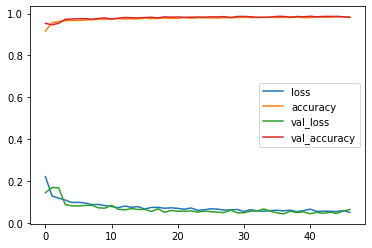

In [8]:
#hierarchical layer
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#defining the MLP:

model_hierarchical = Sequential()

model_hierarchical.add(Dense(units=X_train_hierarchical.shape[1],activation='relu'))
model_hierarchical.add(Dropout(0.5))
model_hierarchical.add(Dense(units=256,activation='relu'))
model_hierarchical.add(Dropout(0.5))
model_hierarchical.add(Dense(units=128,activation='relu'))
#model_hierarchical.add(Dropout(0.5))
#model_hierarchical.add(Dense(units=64,activation='relu'))

#output layer
model_hierarchical.add(Dense(units=len(cm_classes_hierarchical),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model_hierarchical.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])



#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train_hierarchical, y_train_hierarchical_keras,
                                            sampler=RandomUnderSampler(), batch_size=3*8)'''

training_generator, steps_per_epoch = balanced_batch_generator(X_train_hierarchical, y_train_hierarchical_keras, 
                                      sampler=RandomOverSampler(), batch_size=3*8)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model_hierarchical.fit_generator(generator=training_generator, steps_per_epoch=600, epochs=600, verbose=1,
                                       callbacks=[early_stop,tensorboard_callback],validation_data=(X_valid_hierarchical, y_valid_hierarchical_keras))



'''model_hierarchical.fit(x=X_train_hierarchical,
          y=y_train_hierarchical_keras, epochs=600, verbose=1,
                                       callbacks=[early_stop],validation_data=(X_valid_hierarchical, y_valid_hierarchical_keras))
'''
model_loss = pd.DataFrame(model_hierarchical.history.history)
model_loss.plot()
plt.savefig('stat_MLP/model_hierarchical_history.png')

features_hierarchical = list(X_hierarchical)

#with open(model_first_layer, 'wb') as pickle_file:
#        model_dump = {
#            'MLP_model': model_hierarchical,
#            'features': features_hierarchical,
#            }
#        pickle.dump(model_dump, pickle_file)


In [9]:
model_hierarchical.save(model_first_layer+'.h5')



[[  343     1     0]
 [   36  6773   133]
 [   12   241 16968]]
Normalized confusion matrix
[[100.   0.   0.]
 [  1.  98.   2.]
 [  0.   1.  99.]]
[[9.9868089e-01 1.3190554e-03 1.2255159e-14]
 [9.9991155e-01 8.8461456e-05 3.6545728e-20]
 [6.8637096e-06 9.9999309e-01 6.0691452e-11]
 ...
 [2.8785389e-02 9.7088641e-01 3.2820378e-04]
 [9.9911731e-01 8.8262302e-04 2.6370977e-15]
 [7.6782403e-09 1.0000000e+00 3.2040520e-17]]


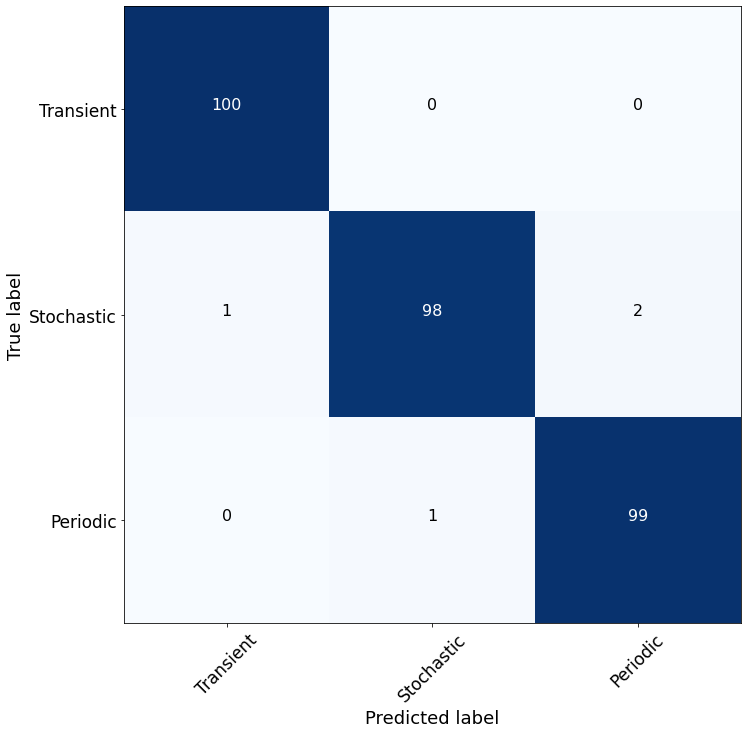

In [10]:
#predictions

predictions_hierarchical = model_hierarchical.predict_classes(X_test_hierarchical)
proba_hierarchical = model_hierarchical.predict(X_test_hierarchical)
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_hierarchical, le_hierarchical.inverse_transform(predictions_hierarchical), labels=cm_classes_hierarchical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierarchical,conf_matrix_name_first_layer)

print(proba_hierarchical)

In [11]:
print("Accuracy:", metrics.accuracy_score(y_test_hierarchical, le_hierarchical.inverse_transform(predictions_hierarchical)))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_hierarchical, le_hierarchical.inverse_transform(predictions_hierarchical)))
print("macro precision: ", metrics.precision_score(y_test_hierarchical, le_hierarchical.inverse_transform(predictions_hierarchical), average='macro'))
print("macro recall: ", metrics.recall_score(y_test_hierarchical, le_hierarchical.inverse_transform(predictions_hierarchical), average='macro'))
print("macro F1: ", metrics.f1_score(y_test_hierarchical, le_hierarchical.inverse_transform(predictions_hierarchical), average='macro'))



Accuracy: 0.9827396254131473
Balanced accuracy: 0.9860190295912551
macro precision:  0.944987674451049
macro recall:  0.9860190295912551
macro F1:  0.9642131044830773


(array([17101.,     0.,     0.,     0.,     0.,  7015.,     0.,     0.,
            0.,   391.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

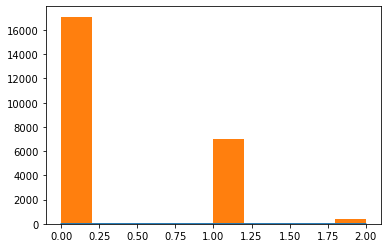

In [12]:
plt.plot(np.arange(3),proba_hierarchical[0])
classe = np.argmax(proba_hierarchical,axis=1)
plt.hist(classe)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[2 4 5 6 7 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/600
800/800 [==============================] - 73s 91ms/step - loss: 1.0830 - accuracy: 0.4487 - val_loss: 0.6190 - val_accuracy: 0.8098
Epoch 2/600
800/800 [==============================] - 73s 91ms/step - loss: 0.7508 - accuracy: 0.7112 - val_loss: 0.6622 - val_accuracy: 0.7626
Epoch 3/600
800/800 [==============================] - 72s 90ms/step - loss: 0.6550 - accuracy: 0.7527 - val_loss: 0.5310 - val_accuracy: 0.8201
Epoch 4/600
800/800 [==============================] - 72s 89ms/step - loss: 0.6034 - accuracy: 0.7789 - val_loss: 0.4660 - val_accuracy: 0.8431
Epoch 5/600
800/800 [==============================] - 72s 90ms/step - loss: 0.5676 - accuracy: 0.7931 - val_loss: 0.4606 - val_accuracy: 0.8452
Epoch 6/600
800/800 [==============================] - 71s 89ms/step - loss: 0.5373 - accuracy: 0.8072 - val_loss: 0.4884 - val_accuracy: 0.8387
Epoch 7/600
800/800 [==============================] - 72s 90ms/step - loss: 0.5042 - accuracy: 0.8121 - val_loss: 0.4684 - val_ac

800/800 [==============================] - 71s 89ms/step - loss: 0.2611 - accuracy: 0.9121 - val_loss: 0.3002 - val_accuracy: 0.8999
Epoch 58/600
800/800 [==============================] - 71s 89ms/step - loss: 0.2529 - accuracy: 0.9179 - val_loss: 0.3050 - val_accuracy: 0.8968
Epoch 59/600
800/800 [==============================] - 71s 89ms/step - loss: 0.2498 - accuracy: 0.9136 - val_loss: 0.2941 - val_accuracy: 0.9010
Epoch 60/600
800/800 [==============================] - 72s 89ms/step - loss: 0.2685 - accuracy: 0.9082 - val_loss: 0.2784 - val_accuracy: 0.9076
Epoch 61/600
800/800 [==============================] - 71s 89ms/step - loss: 0.2478 - accuracy: 0.9170 - val_loss: 0.2842 - val_accuracy: 0.9069
Epoch 62/600
800/800 [==============================] - 71s 89ms/step - loss: 0.2476 - accuracy: 0.9120 - val_loss: 0.2814 - val_accuracy: 0.9069
Epoch 63/600
800/800 [==============================] - 71s 89ms/step - loss: 0.2498 - accuracy: 0.9158 - val_loss: 0.2803 - val_accuracy

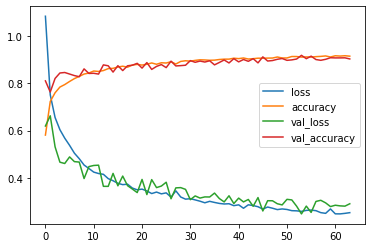

In [13]:
#Periodic layer

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#defining the MLP:

model_periodic = Sequential()

model_periodic.add(Dense(units=X_train_periodic.shape[1],activation='relu'))
model_periodic.add(Dropout(0.5))
model_periodic.add(Dense(units=256,activation='relu'))
model_periodic.add(Dropout(0.5))
model_periodic.add(Dense(units=128,activation='relu'))
#model_periodic.add(Dropout(0.5))
#model_periodic.add(Dense(units=64,activation='relu'))

#output layer
model_periodic.add(Dense(units=len(cm_classes_original),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model_periodic.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train_periodic, y_train_periodic_keras,
                                            sampler=RandomUnderSampler(), batch_size=7*8)'''

training_generator, steps_per_epoch = balanced_batch_generator(X_train_periodic, y_train_periodic_keras,
                                      sampler=RandomOverSampler(), batch_size=6*4)

'''training_generator = balanced_batch_generator(X_train_periodic, y_train_periodic_keras, batch_size=7*8)'''

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model_periodic.fit_generator(generator=training_generator, steps_per_epoch=800, epochs=600, verbose=1,
                                       callbacks=[early_stop,tensorboard_callback],validation_data=(X_valid_periodic, y_valid_periodic_keras))



model_loss = pd.DataFrame(model_periodic.history.history)
model_loss.plot()
plt.savefig('stat_MLP/model_periodic_history.png')

#with open(model_periodic_layer, 'wb') as pickle_file:
#        model_dump = {
#            'MLP_model': model_periodic,
#            'features': features_hierarchical,
#            }
#        pickle.dump(model_dump, pickle_file)


model_periodic.save(model_periodic_layer+'.h5')



In [14]:
#predictions

predictions_periodic = model_periodic.predict_classes(X_test_periodic)
proba_periodic = model_periodic.predict(X_test_periodic)

print(proba_periodic)

[[1.9304899e-21 8.8107280e-21 3.8986534e-02 ... 3.6796306e-21
  9.1418063e-21 2.3735095e-22]
 [7.4614537e-17 3.1949130e-17 5.3593877e-04 ... 4.2607266e-17
  5.3463717e-17 6.5766259e-17]
 [1.2733541e-14 1.6585444e-14 3.9660576e-04 ... 1.5218063e-14
  5.2062978e-14 2.8148025e-14]
 ...
 [3.7376695e-12 8.3760603e-12 6.3199671e-03 ... 1.4436417e-11
  2.7981697e-11 1.2438990e-11]
 [1.4307632e-19 1.2459217e-19 6.3890399e-04 ... 1.2882499e-19
  1.8674271e-19 2.8963796e-19]
 [6.9617359e-12 6.5479341e-12 2.2257330e-01 ... 6.2345472e-12
  2.5335621e-11 8.2136546e-12]]


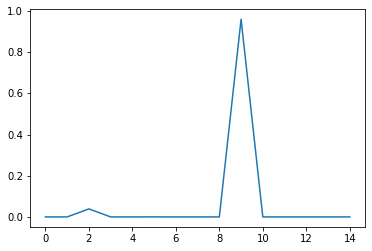

In [15]:
plt.plot(np.arange(len(label_order)),proba_periodic[0])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[ 0  1  3  8 14] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/600
800/800 [==============================] - 67s 83ms/step - loss: 0.8721 - accuracy: 0.5122 - val_loss: 0.6587 - val_accuracy: 0.7935
Epoch 2/600
800/800 [==============================] - 65s 81ms/step - loss: 0.6163 - accuracy: 0.7602 - val_loss: 0.5372 - val_accuracy: 0.8353
Epoch 3/600
800/800 [==============================] - 65s 81ms/step - loss: 0.5618 - accuracy: 0.7840 - val_loss: 0.5405 - val_accuracy: 0.8396
Epoch 4/600
800/800 [==============================] - 65s 81ms/step - loss: 0.5080 - accuracy: 0.8077 - val_loss: 0.6896 - val_accuracy: 0.7969
Epoch 5/600
800/800 [==============================] - 65s 81ms/step - loss: 0.5047 - accuracy: 0.8131 - val_loss: 0.4572 - val_accuracy: 0.8781
Epoch 6/600
800/800 [==============================] - 65s 81ms/step - loss: 0.4772 - accuracy: 0.8214 - val_loss: 0.4345 - val_accuracy: 0.8734
Epoch 7/600
800/800 [==============================] - 65s 81ms/step - loss: 0.4729 - accuracy: 0.8258 - val_loss: 0.3863 - val_ac

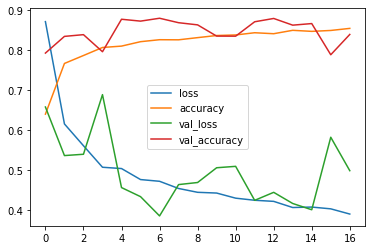

In [16]:
#Stochastic layer

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#defining the MLP:

model_stochastic = Sequential()

model_stochastic.add(Dense(units=X_train_stochastic.shape[1],activation='relu'))
model_stochastic.add(Dropout(0.5))
model_stochastic.add(Dense(units=256,activation='relu'))
model_stochastic.add(Dropout(0.5))
model_stochastic.add(Dense(units=128,activation='relu'))
#model_stochastic.add(Dropout(0.5))
#model_stochastic.add(Dense(units=64,activation='relu'))

#output layer
model_stochastic.add(Dense(units=len(cm_classes_original),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model_stochastic.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train_stochastic, y_train_stochastic_keras,
                                            sampler=RandomUnderSampler(), batch_size=6*8)'''

training_generator, steps_per_epoch = balanced_batch_generator(X_train_stochastic, y_train_stochastic_keras,
                                      sampler=RandomOverSampler(), batch_size=5*4)

'''training_generator = balanced_batch_generator(X_train_stochastic, y_train_stochastic_keras, batch_size=6*8)
'''
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model_stochastic.fit_generator(generator=training_generator, steps_per_epoch=800, epochs=600, verbose=1,
                                       callbacks=[early_stop,tensorboard_callback],validation_data=(X_valid_stochastic, y_valid_stochastic_keras))



model_loss = pd.DataFrame(model_stochastic.history.history)
model_loss.plot()
plt.savefig('stat_MLP/model_stochastic_history.png')

model_stochastic.save(model_stochastic_layer+'.h5')




In [17]:
#predictions

predictions_stochastic = model_stochastic.predict_classes(X_test_stochastic)
proba_stochastic = model_stochastic.predict(X_test_stochastic)

print(proba_stochastic)



[[1.4756076e-08 4.8940126e-07 4.2505181e-36 ... 5.0374931e-38
  8.6203409e-38 5.3299787e-05]
 [1.1906643e-04 7.4690720e-04 8.2245237e-18 ... 1.8181862e-18
  1.1430776e-18 2.2718802e-02]
 [3.4241447e-01 2.2239901e-01 1.5028031e-07 ... 1.1657256e-07
  1.1009883e-07 1.7135894e-03]
 ...
 [1.3321969e-01 6.0761657e-02 3.3428375e-08 ... 7.0864541e-09
  1.3496859e-08 7.8229254e-01]
 [1.0208095e-02 9.1680903e-03 1.6213341e-09 ... 2.4558786e-10
  9.0894492e-10 6.9790381e-01]
 [2.5672348e-02 8.6109497e-02 9.0333660e-16 ... 3.2744028e-16
  3.8897111e-16 9.2402643e-06]]


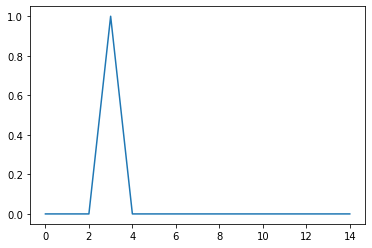

In [18]:
plt.plot(np.arange(len(label_order)),proba_stochastic[0])

Epoch 1/600


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[10 11 12 13] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


203/203 [==============================] - 17s 83ms/step - loss: 1.3700 - accuracy: 0.3164 - val_loss: 1.2830 - val_accuracy: 0.2145
Epoch 2/600
203/203 [==============================] - 16s 78ms/step - loss: 1.0144 - accuracy: 0.5228 - val_loss: 1.0481 - val_accuracy: 0.4218
Epoch 3/600
203/203 [==============================] - 15s 75ms/step - loss: 0.8539 - accuracy: 0.5899 - val_loss: 1.1051 - val_accuracy: 0.2691
Epoch 4/600
203/203 [==============================] - 15s 75ms/step - loss: 0.7485 - accuracy: 0.6600 - val_loss: 0.9070 - val_accuracy: 0.6218
Epoch 5/600
203/203 [==============================] - 15s 75ms/step - loss: 0.6936 - accuracy: 0.6824 - val_loss: 0.8652 - val_accuracy: 0.6436
Epoch 6/600
203/203 [==============================] - 15s 75ms/step - loss: 0.6556 - accuracy: 0.6963 - val_loss: 0.9400 - val_accuracy: 0.5636
Epoch 7/600
203/203 [==============================] - 15s 75ms/step - loss: 0.6159 - accuracy: 0.7304 - val_loss: 0.7260 - val_accuracy: 0.76

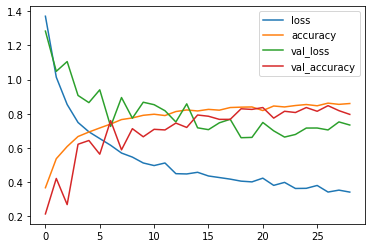

In [19]:
#Transient layer

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#defining the MLP:

model_transient = Sequential()

model_transient.add(Dense(units=X_train_transient.shape[1],activation='relu'))
model_transient.add(Dropout(0.5))
model_transient.add(Dense(units=256,activation='relu'))
model_transient.add(Dropout(0.5))
model_transient.add(Dense(units=128,activation='relu'))
#model_transient.add(Dropout(0.5))
#model_transient.add(Dense(units=64,activation='relu'))
#model_transient.add(Dropout(0.5))

#output layer
model_transient.add(Dense(units=len(cm_classes_original),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model_transient.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train_transient, y_train_transient_keras,
                                            sampler=RandomUnderSampler(), batch_size=4*8)'''
training_generator, steps_per_epoch = balanced_batch_generator(X_train_transient, y_train_transient_keras,
                                      sampler=RandomOverSampler(), batch_size=4*4)

'''training_generator = balanced_batch_generator(X_train_transient, y_train_transient_keras, batch_size=4*8)
'''
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model_transient.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=600, verbose=1,
                                       callbacks=[early_stop,tensorboard_callback],validation_data=(X_valid_transient, y_valid_transient_keras))



model_loss = pd.DataFrame(model_transient.history.history)
model_loss.plot()
plt.savefig('stat_MLP/model_transient_history.png')



model_transient.save(model_transient_layer+'.h5')



In [20]:

#predictions

predictions_transient = model_transient.predict_classes(X_test_transient)
proba_transient = model_transient.predict(X_test_transient)

print(proba_transient)

[[5.3516982e-05 6.3238607e-05 7.2036673e-05 ... 2.2055000e-01
  6.6616759e-02 4.6032954e-05]
 [1.8768168e-24 6.1814916e-24 7.5797669e-23 ... 5.7151105e-04
  6.3791938e-10 2.1186313e-24]
 [1.2364918e-21 4.5660451e-22 1.4114068e-21 ... 9.9987495e-01
  3.4019541e-09 2.7644009e-22]
 ...
 [2.4850438e-10 4.4456869e-10 6.4918704e-10 ... 2.1679536e-02
  2.6255762e-03 2.0144351e-10]
 [1.2424506e-23 5.3315000e-23 3.8405763e-22 ... 2.2430561e-04
  2.2371198e-09 1.0823048e-23]
 [1.0776682e-20 6.5437733e-21 1.2127277e-20 ... 9.9968314e-01
  3.3166934e-08 3.3975595e-21]]


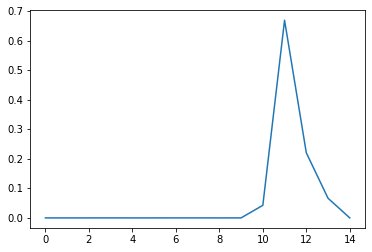

In [21]:
plt.plot(np.arange(len(label_order)),proba_transient[0])

Normalized confusion matrix
[[80. 13.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [68. 11. 16.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [21. 12. 65.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [40.  0.  0. 60.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 83. 13.  3.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  7. 87.  4.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. 21. 23. 53.  2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1. 69.  1.  7.  9.  0.  2.  8.  0.]
 [ 6.  2.  4.  0.  2.  0.  2.  2. 61.  1.  3.  3. 13.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 98.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  0. 85.  4.  4.  2.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10. 84.  7.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  3.  1. 91.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  9.  0. 13. 74.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  2. 26.  0. 29.  7. 33.]]
Accuracy: 0.86885379687436

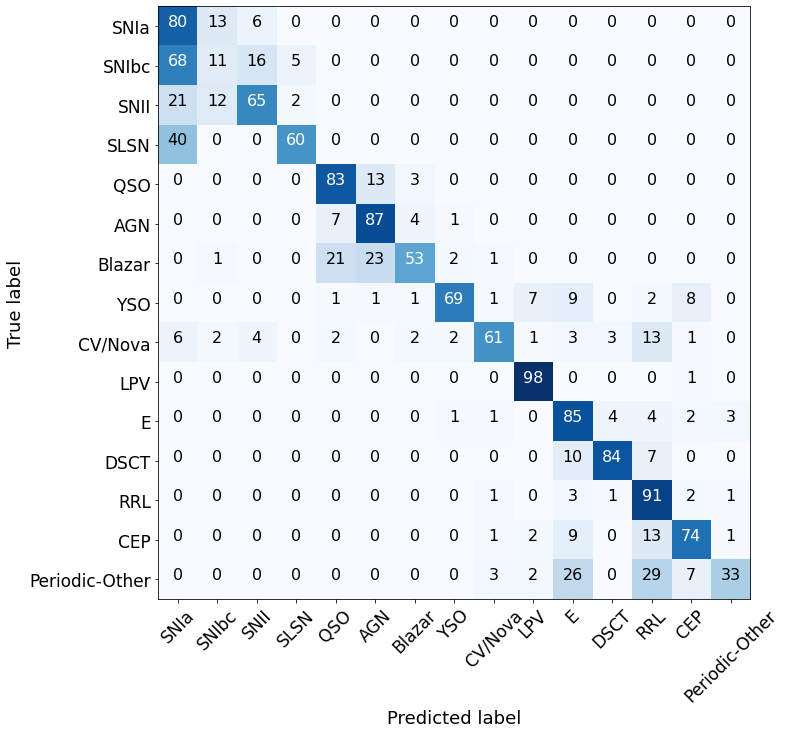

In [22]:

# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = proba_periodic*proba_hierarchical[:,0].T[:, np.newaxis]
prob_stochastic = proba_stochastic*proba_hierarchical[:,1].T[:, np.newaxis]
prob_trainsient = proba_transient*proba_hierarchical[:,2].T[:, np.newaxis]

#obtaining final probabilities matrix
#prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

prob_final = prob_periodic + prob_stochastic + prob_trainsient

#print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = le_original.inverse_transform(class_final_index)

#print(class_final_name)


# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
#print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, '../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_MLP.pdf')

print("Accuracy:", metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("macro precision: ","%0.3f" %  metrics.precision_score(y_test_original, class_final_name, average='macro'))
print("macro recall: ","%0.3f" %  metrics.recall_score(y_test_original, class_final_name, average='macro'))
print("macro F1: ","%0.3f" %  metrics.f1_score(y_test_original, class_final_name, average='macro'))




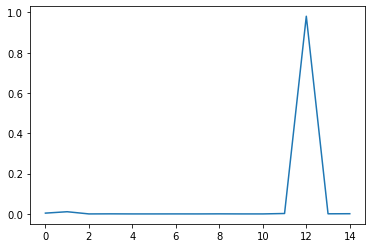

In [23]:
plt.plot(np.arange(len(label_order)),prob_final[90])

In [24]:
# Kaggle score

num_y_test =  class_final_index#[np.where(label_order==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))



print(class_weights)

CLASSES_REDUCED_V2 = label_order#prob_final_class_names

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final,class_weights))

[6.432283464566929, 85.98947368421052, 24.754545454545454, 326.76, 0.3121513183034008, 1.7511254019292604, 6.4577075098814225, 4.694827586206896, 9.389655172413793, 0.5803907637655418, 0.2155124653739612, 11.19041095890411, 0.2514699091888564, 13.175806451612903, 28.16896551724138]
SNIa -2.0670689780411755
SNIbc -38.43183082373518
SNII -9.649756648594682
SLSN -121.8648652946949
QSO -0.10667194400778425
AGN -0.3022812212107649
Blazar -0.36248247386085186
YSO -1.7877756947587276
CV/Nova -2.918840298673202
LPV -0.08073591857248683
E -0.07300392379390896
DSCT -3.7223208524592937
RRL -0.05838249868680207
CEP -5.27070629740915
Periodic-Other -7.818284121258506
0.3739779075774354


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['SNIa', 'SNIbc', 'SNII', 'SLSN', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova', 'LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other'], y=oid
ZTF19aatnfrd    RRL
ZTF18abccrax      E
ZTF20aakywxx    AGN
ZTF18aajjlpx    QSO
ZTF20aandrro    QSO
               ... 
ZTF18acmysxl    YSO
ZTF19aaxtzaz    LPV
ZTF19aaeqxvi    YSO
ZTF18actsxbc      E
ZTF18aceyzsb    QSO
Name: class_original, Length: 24507, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


   ## Classifying unlabeled data

In [25]:
#loading the data

#print(df_feat.n_samples_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

#print(df_feat_ul.n_samples_1.size)

    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()



['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1', 'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2']


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaavn,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,0.428571,0.0,0.0,...,0.738809,0.989375,-0.301,1.491,4.239709,2.748709,5.350475,3.859475,0.017990,4.895612e-01
ZTF17aaaadjh,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,0.293103,0.0,0.0,...,0.742857,1.000000,-0.125,2.380,4.533904,2.153904,5.281445,2.901445,0.000011,5.197596e-08
ZTF17aaaadwo,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,0.285714,0.0,0.0,...,0.737143,0.992667,-0.065,1.602,4.344352,2.742352,5.495974,3.893974,0.423044,2.662193e-01
ZTF17aaaajjv,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,0.481203,0.0,0.0,...,0.743333,1.000000,-0.040,0.997,7.765696,6.768696,10.193531,9.196531,29.239637,1.437226e-04
ZTF17aaaakjt,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,0.350000,0.0,0.0,...,0.818571,0.975000,-0.027,0.027,3.161238,3.134238,4.298826,4.271826,0.000002,2.169809e-06


In [26]:
#predicting classes of unlabeled data

df_feat_ul_scaled = scaler.transform(df_feat_ul.values)
test_Y_hierarchical = model_hierarchical.predict(df_feat_ul_scaled)
test_Y_proba_hierarchical = model_hierarchical.predict_proba(df_feat_ul_scaled)

test_Y_periodic = model_periodic.predict(df_feat_ul_scaled)
test_Y_proba_periodic = model_periodic.predict_proba(df_feat_ul_scaled)

test_Y_stochastic = model_stochastic.predict(df_feat_ul_scaled)
test_Y_proba_stochastic = model_stochastic.predict_proba(df_feat_ul_scaled)

test_Y_transient = model_transient.predict(df_feat_ul_scaled)
test_Y_proba_transient = model_transient.predict_proba(df_feat_ul_scaled)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,0].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,1].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,2].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = prob_stochastic_ul+prob_trainsient_ul+prob_periodic_ul

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul =  le_original.inverse_transform(class_final_index_ul) 

[0.99999994 1.         1.         ... 0.99999994 1.         0.99999994] 1.0 8.380147e-08


In [27]:
#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)

NameError: name 'classes_order_proba_stochastic' is not defined

In [28]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out

'''
probs_header = le_original.inverse_transform(prob_final_class_names) + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

#test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

(868371, 152)
868371
868371


"\nprobs_header = le_original.inverse_transform(prob_final_class_names) + '_prob'\n\nprob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)\n\nprob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)\n\ntest_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)\n\n#test_data_withclass.to_csv(class_output)\n\ntest_data_withclass.head()\n"

Counter({'E': 349462, 'LPV': 201891, 'RRL': 85811, 'YSO': 74740, 'QSO': 42094, 'CEP': 31435, 'DSCT': 21540, 'AGN': 19533, 'CV/Nova': 14602, 'Blazar': 11092, 'Periodic-Other': 7330, 'SNIa': 4774, 'SNII': 2654, 'SNIbc': 1240, 'SLSN': 173})
                number
E               349462
LPV             201891
RRL              85811
YSO              74740
QSO              42094
CEP              31435
DSCT             21540
AGN              19533
CV/Nova          14602
Blazar           11092
Periodic-Other    7330
SNIa              4774
SNII              2654
SNIbc             1240
SLSN               173


Text(0, 0.5, '$\\#$ of sources')

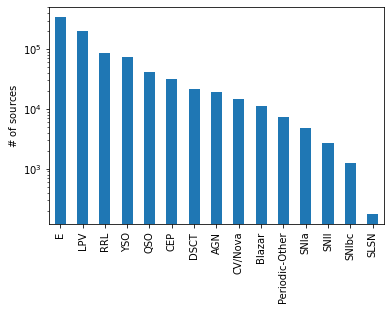

In [29]:
'''letter_counts = Counter(class_final_name_ul)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')'''

class_counts = Counter(class_final_name_ul)
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of sources')

0 SNIa 0.8198312520980835
1 SNIbc 0.6801897287368774
2 SNII 0.7214725315570831
3 SLSN 0.7586395144462585
4 QSO 0.7348409593105316
5 AGN 0.7323784232139587
6 Blazar 0.5264732837677002
7 YSO 0.7329354286193848
8 CV/Nova 0.5199278593063354
9 LPV 0.9499529600143433
10 E 0.8329620361328125
11 DSCT 0.6827807128429413
12 RRL 0.8342731595039368
13 CEP 0.6558091640472412
14 Periodic-Other 0.6685043573379517


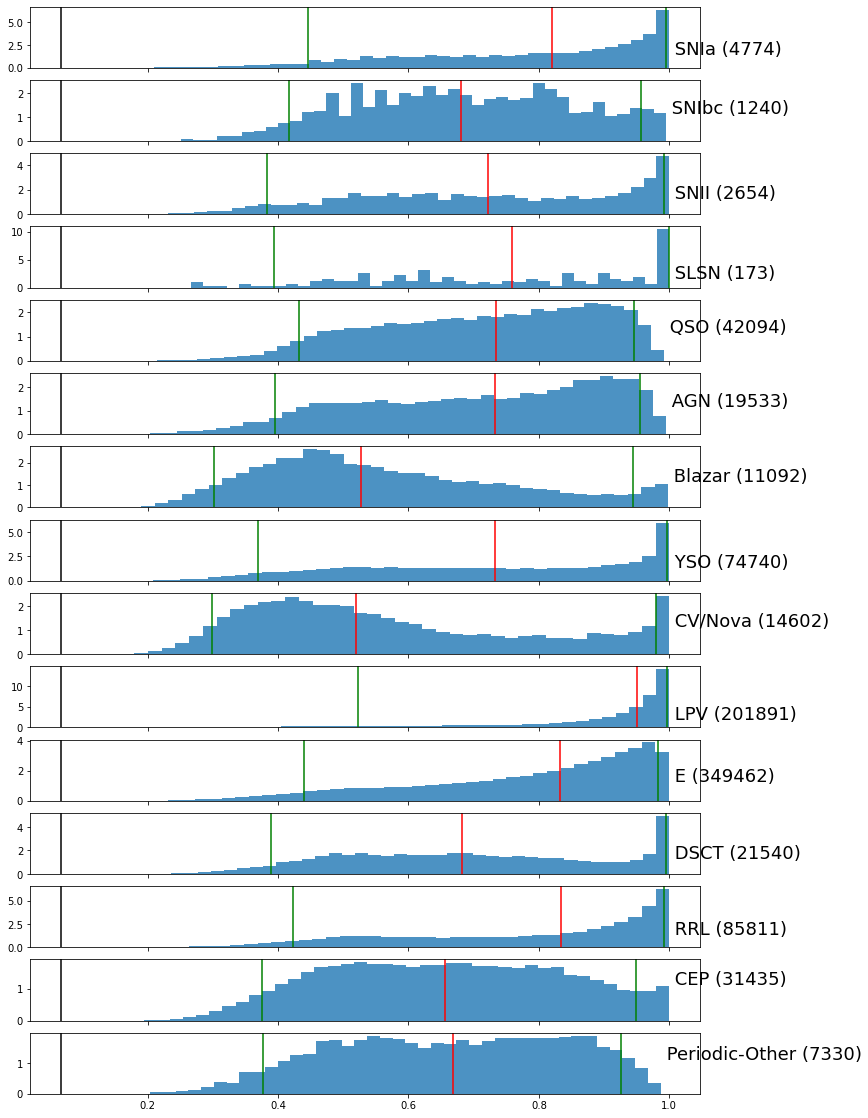

In [30]:
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

[ 0.28745954  0.01148621 -0.00761852 ...  0.07376862  0.05683932
  0.0118779 ]


[Text(1, 0, '0.2'),
 Text(1, 0, '0.3'),
 Text(1, 0, '0.4'),
 Text(1, 0, '0.5'),
 Text(1, 0, '0.6'),
 Text(1, 0, '0.7')]

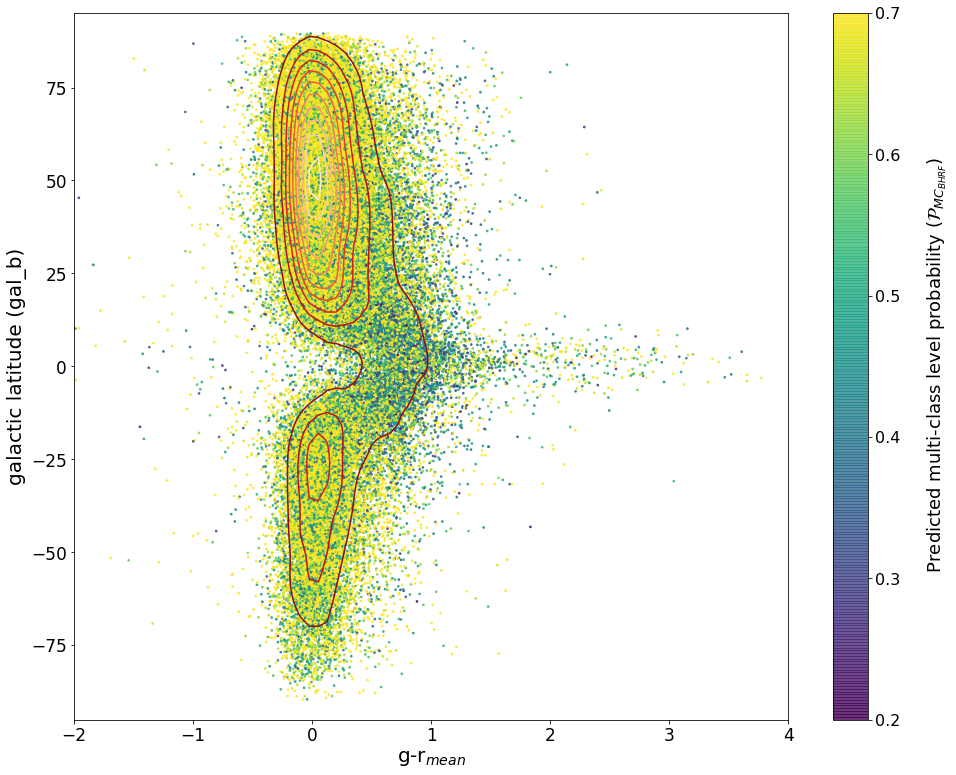

In [31]:
import matplotlib.cm as cm
import seaborn as sns

feature_x = 'g-r_mean'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
color_list = []

for idx, cl in enumerate(labels_list):
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   color_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
    
gal_b_array = np.array(gal_b_list)
color_array = np.array(color_list)

print(color_array)

ax = sns.kdeplot(color_array,gal_b_array, n_levels=10, cmap="Reds_r", shade=False)
    
cbar = plt.colorbar(sc)
cbar.set_label('\n Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$) ', rotation=90,fontsize=18)

#plt.legend(fontsize=15)
plt.xlabel(r'g-r$_{mean}$',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

[ 90.84914758 172.52388507  94.20044171 ... 139.61568137 206.93353738
 104.20778198]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.]),
 <a list of 9 Text major ticklabel objects>)

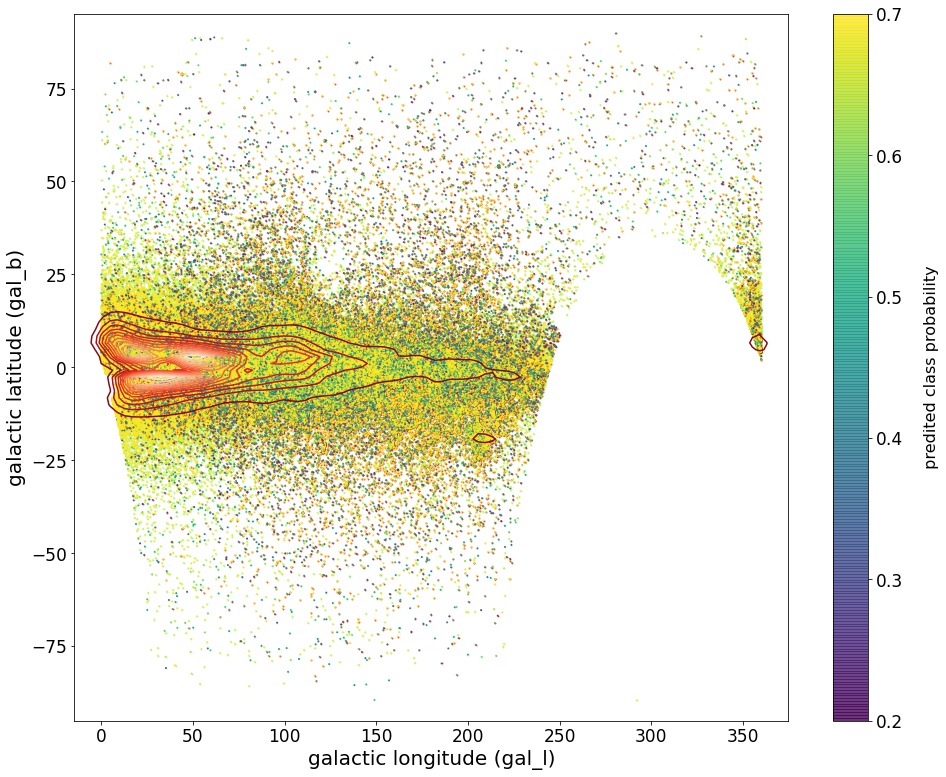

In [32]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['Ceph','LPV','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

